In [38]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import cv2
import glob

In [164]:
data_dir = '/home/aracely/aitraveling/cities'
labels = ["agra", "cdmx", "dubai", "newyork", "paris", "shanhaiguan", "sydney"]
for label in labels:
    image_count = len(glob.glob(data_dir+"/"+label+"/*"))
    print(label+": "+str(image_count))

agra: 166
cdmx: 162
dubai: 478
newyork: 443
paris: 248
shanhaiguan: 164
sydney: 510


In [97]:
images = {}
for label in labels:
    images[label] = glob.glob(data_dir+"/"+label+"/*")
# imgs_china = glob.glob(data_dir+"/china/*")
# imgs_india = glob.glob(data_dir+"/india/*")
# imgs_mexico = glob.glob(data_dir+"/mexico/*")

In [98]:
print(len(images["agra"]))

166


## Load data using a Keras utility

### Create a dataset

In [99]:
batch_size = 32
img_height = 180
img_width = 180

In [100]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2171 files belonging to 7 classes.
Using 1737 files for training.


In [101]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2171 files belonging to 7 classes.
Using 434 files for validation.


In [102]:
class_names = train_ds.class_names
print(class_names)

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']


## Visualize the data

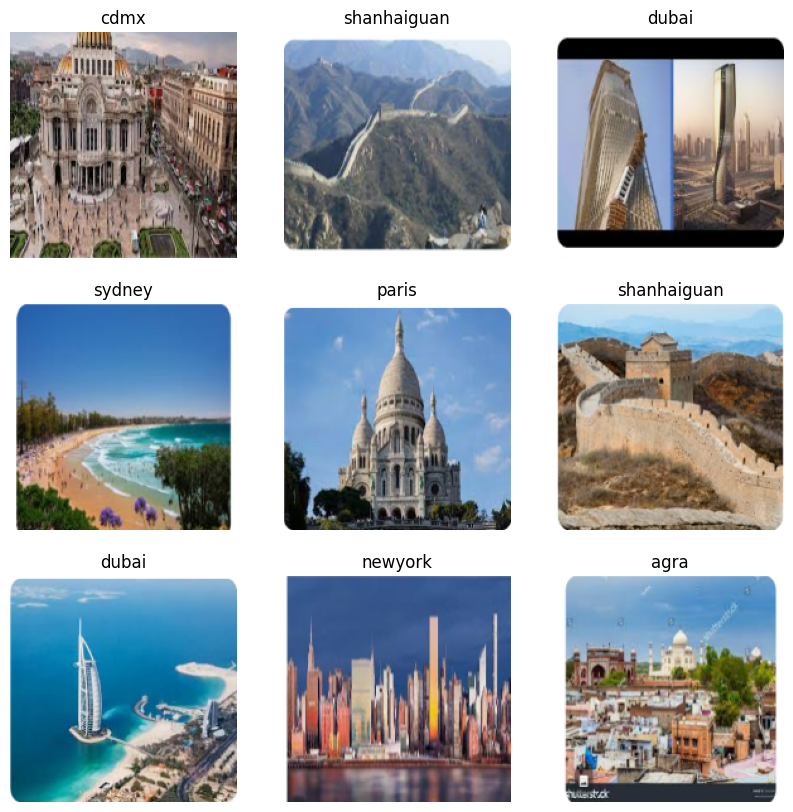

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [104]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [105]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [106]:
normalization_layer = layers.Rescaling(1./255)

In [107]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

### Create the model

In [108]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [110]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [111]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
55/55 [==============================] - 12s 205ms/step - loss: 1.8783 - accuracy: 0.2418 - val_loss: 1.7359 - val_accuracy: 0.2834
Epoch 2/12
55/55 [==============================] - 11s 197ms/step - loss: 1.7225 - accuracy: 0.2879 - val_loss: 1.6164 - val_accuracy: 0.3687
Epoch 3/12
55/55 [==============================] - 11s 191ms/step - loss: 1.5524 - accuracy: 0.3995 - val_loss: 1.5829 - val_accuracy: 0.3825
Epoch 4/12
55/55 [==============================] - 11s 191ms/step - loss: 1.3126 - accuracy: 0.4963 - val_loss: 1.5213 - val_accuracy: 0.4286
Epoch 5/12
55/55 [==============================] - 10s 191ms/step - loss: 1.0469 - accuracy: 0.6200 - val_loss: 1.5573 - val_accuracy: 0.4378
Epoch 6/12
55/55 [==============================] - 11s 194ms/step - loss: 0.8249 - accuracy: 0.7116 - val_loss: 1.7603 - val_accuracy: 0.4493
Epoch 7/12
55/55 [==============================] - 11s 193ms/step - loss: 0.5912 - accuracy: 0.7933 - val_loss: 1.7805 - val_accuracy: 0.4493

## Visualize training results

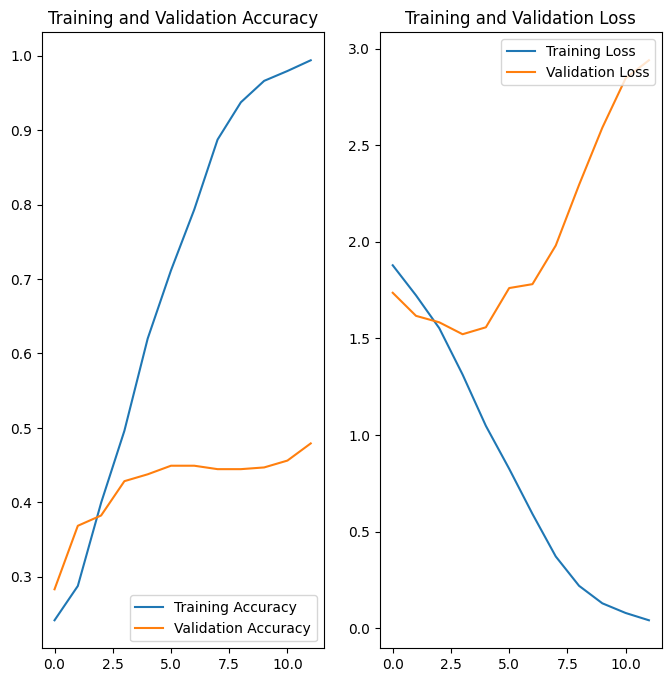

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [113]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

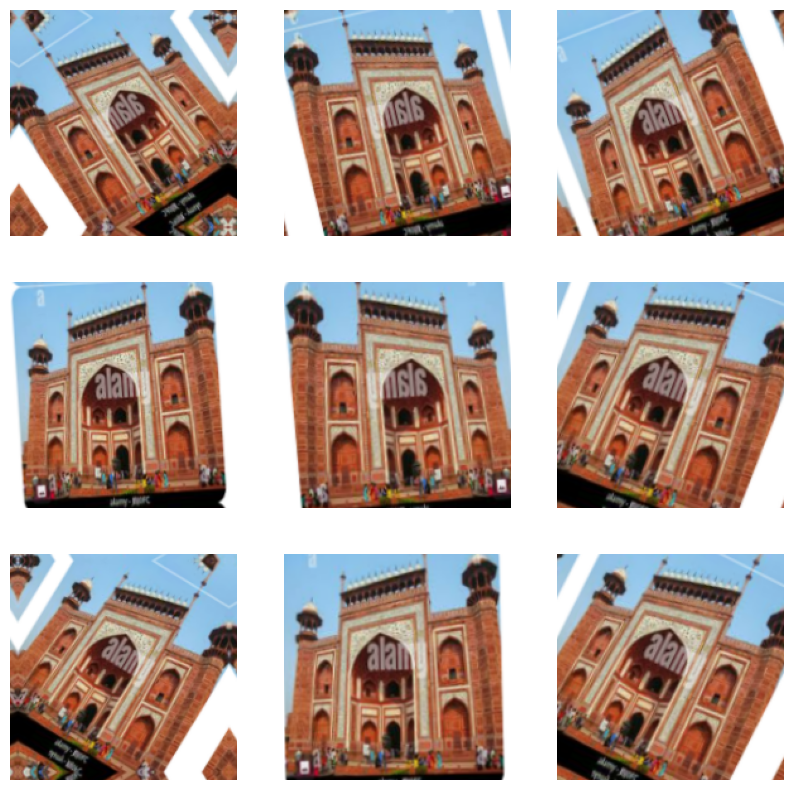

In [114]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [115]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [116]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [118]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
55/55 [==============================] - 14s 242ms/step - loss: 1.8746 - accuracy: 0.2372 - val_loss: 1.7264 - val_accuracy: 0.2742
Epoch 2/15
55/55 [==============================] - 13s 241ms/step - loss: 1.7444 - accuracy: 0.2694 - val_loss: 1.7101 - val_accuracy: 0.2373
Epoch 3/15
55/55 [==============================] - 13s 238ms/step - loss: 1.6683 - accuracy: 0.3155 - val_loss: 1.6583 - val_accuracy: 0.3341
Epoch 4/15
55/55 [==============================] - 13s 243ms/step - loss: 1.6327 - accuracy: 0.3552 - val_loss: 1.6301 - val_accuracy: 0.3779
Epoch 5/15
55/55 [==============================] - 13s 241ms/step - loss: 1.5812 - accuracy: 0.3817 - val_loss: 1.6317 - val_accuracy: 0.3594
Epoch 6/15
55/55 [==============================] - 14s 253ms/step - loss: 1.5384 - accuracy: 0.4134 - val_loss: 1.4841 - val_accuracy: 0.4309
Epoch 7/15
55/55 [==============================] - 16s 290ms/step - loss: 1.4843 - accuracy: 0.4301 - val_loss: 1.4492 - val_accuracy: 0.4585

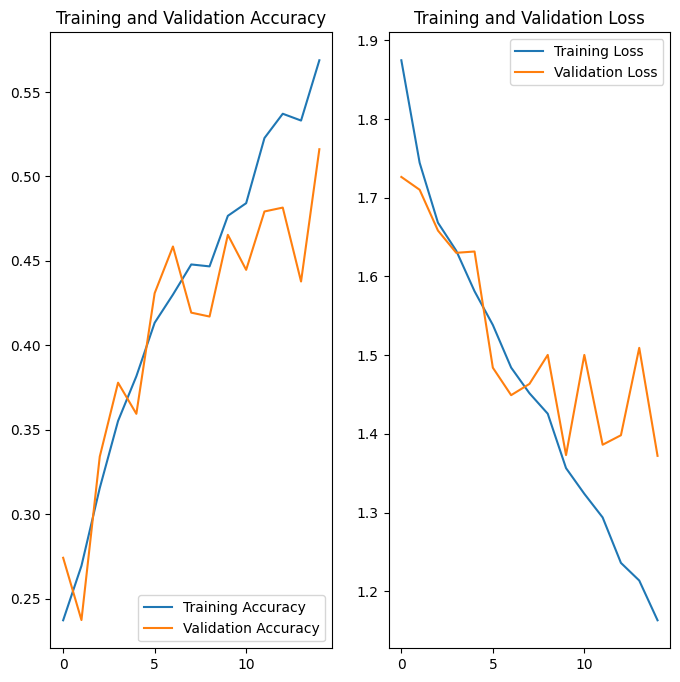

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [120]:
data_dir

'/home/aracely/aitraveling/cities'

In [121]:
img = tf.keras.utils.load_img(
    data_dir+'/agra/(1105).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print()
print(class_names)
# print(type(score))
print(np.array(score))
# img

1/1 [==============================] - 0s 106ms/step
This image most likely belongs to agra with a 53.31 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[5.33106506e-01 3.52415293e-02 3.67442816e-01 4.93146628e-02
 2.70705926e-03 4.50240332e-05 1.21424915e-02]


1/1 [==============================] - 0s 28ms/step
This image most likely belongs to cdmx with a 40.06 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[2.5670673e-04 4.0061900e-01 3.8461879e-01 1.2261138e-01 3.6244672e-02
 6.8658227e-03 4.8783593e-02]


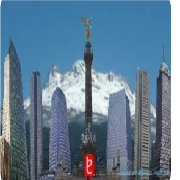

In [122]:
img2 = tf.keras.utils.load_img(
    data_dir+'/cdmx/(10130).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img2

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to cdmx with a 40.06 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[2.5670673e-04 4.0061900e-01 3.8461879e-01 1.2261138e-01 3.6244672e-02
 6.8658227e-03 4.8783593e-02]


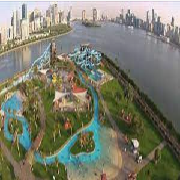

In [128]:
img = tf.keras.utils.load_img(
    data_dir+'/dubai/(10218).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

1/1 [==============================] - 0s 29ms/step
This image most likely belongs to newyork with a 99.52 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[2.7503313e-06 2.2668962e-04 2.8431150e-03 9.9518591e-01 8.0938244e-06
 1.9268423e-06 1.7315792e-03]


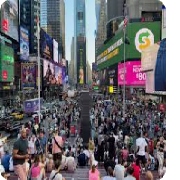

In [129]:
img3 = tf.keras.utils.load_img(
    data_dir+'/newyork/(10237).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img3

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to paris with a 67.11 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[0.0058243  0.11122064 0.07939352 0.11220931 0.6710584  0.00381619
 0.01647762]


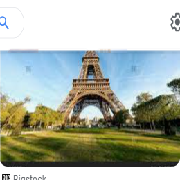

In [130]:
img4 = tf.keras.utils.load_img(
    data_dir+'/paris/(10239).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img4)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img4

1/1 [==============================] - 0s 30ms/step
This image most likely belongs to shanhaiguan with a 82.05 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[1.1576256e-02 5.8558680e-02 1.9251764e-02 8.4572874e-02 7.1056950e-04
 8.2046789e-01 4.8620296e-03]


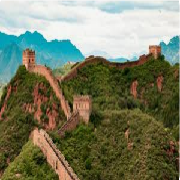

In [131]:
img5 = tf.keras.utils.load_img(
    data_dir+'/shanhaiguan/(10431).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img5

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to shanhaiguan with a 82.05 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[1.1576256e-02 5.8558680e-02 1.9251764e-02 8.4572874e-02 7.1056950e-04
 8.2046789e-01 4.8620296e-03]


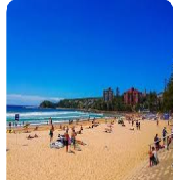

In [151]:
img = tf.keras.utils.load_img(
    data_dir+'/sydney/(10209).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

## Use TensorFlow Lite

### Convert the Keras Sequential model to a TensorFlow Lite model


In [157]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model7.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpz4wjv23r/assets


INFO:tensorflow:Assets written to: /tmp/tmpz4wjv23r/assets
2024-02-23 16:43:26.621807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-23 16:43:26.621881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-23 16:43:26.622177: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpz4wjv23r
2024-02-23 16:43:26.625868: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-23 16:43:26.625895: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpz4wjv23r
2024-02-23 16:43:26.636814: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-23 16:43:26.720523: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpz4wjv23r
2024-02-23 16:43:26.738031: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

### Run the TensorFlow Lite model

In [158]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [159]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_7_input'], 'outputs': ['outputs']}}

In [160]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [161]:
predictions_lite = classify_lite(sequential_7_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to shanhaiguan with a 82.05 percent confidence.

['agra', 'cdmx', 'dubai', 'newyork', 'paris', 'shanhaiguan', 'sydney']
[1.1576256e-02 5.8558680e-02 1.9251764e-02 8.4572874e-02 7.1056950e-04
 8.2046789e-01 4.8620296e-03]


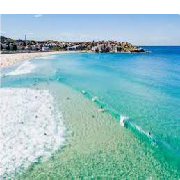

In [162]:
img = tf.keras.utils.load_img(
    data_dir+'/sydney/(10325).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

In [163]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to shanhaiguan with a 82.05 percent confidence.
